# Zillow Project

# Goal:
* Discover features that affect property value 
* Use features to develop a machine learning model to predict property value

In [1]:
import numpy as np
import pandas as pd

import wrangle as w
import explore as e
import model as m
import evaluate as ev

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, f_oneway, ttest_ind

np.random.seed(42)

# Acquire
* Data acquired from Codeup SQL server
* It contained 52,320 rows before cleaning
* Each row represents data from a single property in the Zillow database from 2017
* Each column represents a feature of that property
* All properties are in one of three counties in the state of California: Los Angeles County, Orange County, or Ventura County

# Prepare
* Removed columns that did not contain useful information
* Renamed columns to user-friendly names
* Checked that column data types were appropriate; changed several from float to int
* Checked for nulls in the data
    * has_pool was majority nulls; the rest were 1
    * changed nulls to zero
    * dropped other nulls (~3% of data)
* Checked for outliers
    * Removed rows with property_value > $1.5M
    * Removed rows with lotsize_sqft > 60,000
    * Outliers accounted for ~5% of data
* In total, ~8% of rows were dropped for either containing nulls or being outliers
* Encoded categorical columns
* Split data into train, validate, and test (60/20/20)
* Scaled continuous variables with MinMaxScaler
* Started with 52,320 rows; Ended with 47,949 rows

| Feature | Type | Definition |
|:--------|:-----|:-----------|
|property_value (target)|integer|actual property value|
|bathrooms|float|number of bathrooms|
|bedrooms|integer|number of bedrooms|
|has_pool|integer|0 for no pool, 1 if the propert has a pool|
|squarefeet|integer|square footage of the interior of the home|
|lotsize_sqft|integer|square footage of the lot|
|year|integer|year the home was built|
|county|string|county where the property lies (LA, Orange, Ventura)
|Additional Features|Encoded values for categorical data and scaled versions of continuous data|

In [2]:
# acquireing and preparing data for exploration
df = w.wrangle_zillow()

# splitting data in to train, validate, and test
train, validate, test = w.split_function(df)

csv file found and read
Prepared df: (47949, 10)

Train: (28769, 10)
Validate: (9590, 10)
Test: (9590, 10)


## A Brief look at the data

In [3]:
train.head()

,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county,county_Orange,county_Ventura
46866,476000,2.0,3,0,1606,6447,1955,LA,0,0
43125,567337,2.5,4,1,2642,7912,1977,Orange,1,0
38231,419390,1.0,2,0,924,7155,1948,LA,0,0
20644,409000,1.0,3,0,1402,7165,1953,LA,0,0
46076,342514,3.0,4,0,2826,23650,1978,Orange,1,0


### A summary of the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28769 entries, 46866 to 30727
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_value  28769 non-null  int64  
 1   bathrooms       28769 non-null  float64
 2   bedrooms        28769 non-null  int64  
 3   has_pool        28769 non-null  int64  
 4   squarefeet      28769 non-null  int64  
 5   lotsize_sqft    28769 non-null  int64  
 6   year            28769 non-null  int64  
 7   county          28769 non-null  object 
 8   county_Orange   28769 non-null  uint8  
 9   county_Ventura  28769 non-null  uint8  
dtypes: float64(1), int64(6), object(1), uint8(2)
memory usage: 2.0+ MB


In [5]:
train.describe()

,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county_Orange,county_Ventura
count,2.876900e+04,28769.000000,28769.000000,28769.000000,28769.000000,28769.000000,28769.000000,28769.000000,28769.000000
mean,4.113606e+05,2.187493,3.252007,0.192499,1794.710105,8080.369599,1962.222462,0.271160,0.086934
std,2.988978e+05,0.856950,0.897735,0.394270,768.990768,5881.883488,22.216708,0.444566,0.281743
min,1.000000e+03,0.000000,0.000000,0.000000,128.000000,540.000000,1878.000000,0.000000,0.000000
25%,1.816520e+05,2.000000,3.000000,0.000000,1248.000000,5500.000000,1950.000000,0.000000,0.000000
50%,3.502830e+05,2.000000,3.000000,0.000000,1611.000000,6738.000000,1960.000000,0.000000,0.000000
75%,5.604870e+05,3.000000,4.000000,0.000000,2166.000000,8393.000000,1977.000000,1.000000,0.000000
max,1.500000e+06,10.000000,10.000000,1.000000,9918.000000,59649.000000,2015.000000,1.000000,1.000000


# Explore

## What is the distribution of property_value?

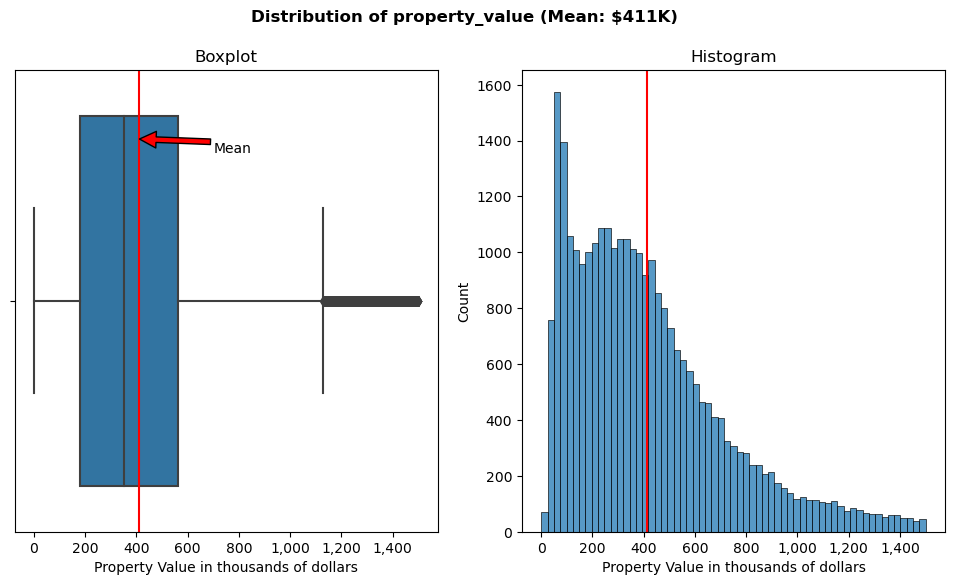

In [6]:
# get a boxplot and histplot of property_value of train
e.get_target_plot(train)

## Is square footage associated with property_value?

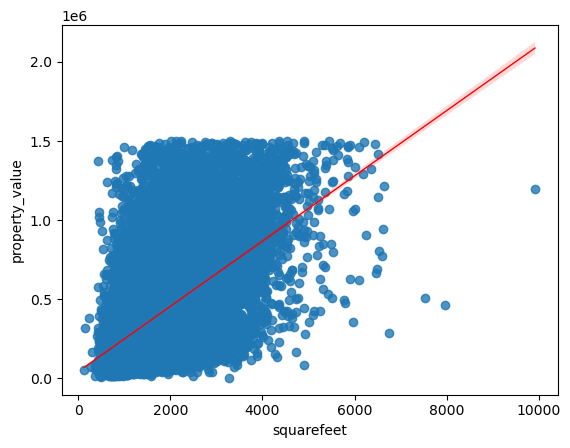

In [7]:
# get a regplot of squarefeet vs property_value on train
e.get_reg_plot(train, 'squarefeet')

### Analyze squarefeet vs property_value with stats
- $H_0$: There is NO relationship between squarefeet and property_value
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize pearsonr - we are comparing continuous variables, normally distributed

In [8]:
# get the stats from a pearsonr test on squarefeet vs property_value
e.get_pearsonr(train, 'squarefeet')

t = 0.5310665469093112
p = 0.0


### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between squarefeet and property_value

## Is number of bathrooms associated with property_value?

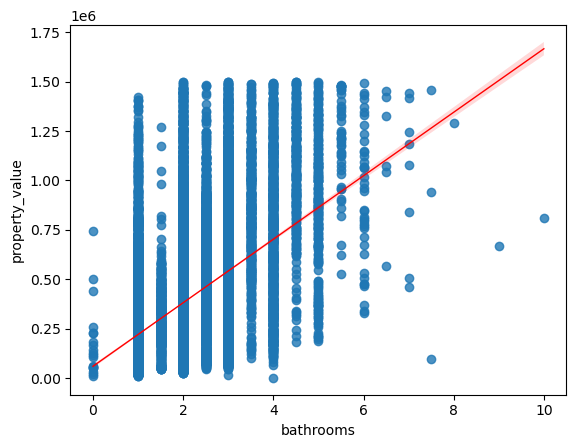

In [9]:
# get a regplot of bathrooms vs property_value on train
e.get_reg_plot(train, 'bathrooms')

### Analyze bathrooms vs property_value with stats
- $H_0$: There is NO relationship between bathrooms and property_value
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize pearsonr - we are comparing continuous variables, normally distributed

In [10]:
# get the stats from a pearsonr test on bathrooms vs property_value
e.get_pearsonr(train, 'bathrooms')

t = 0.4604958756677789
p = 0.0


### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between number of bathrooms and property_value

## Is number of bedrooms associated with property_value?

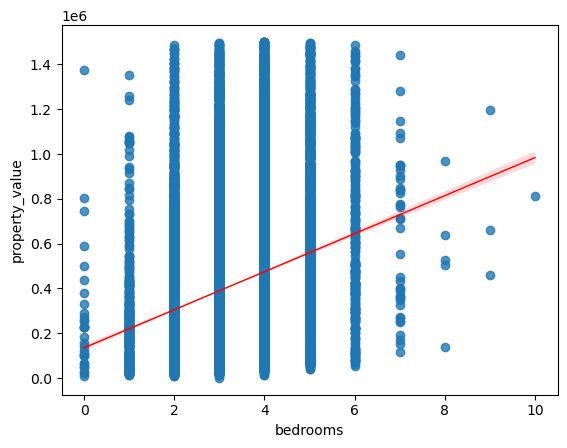

In [11]:
# get a regplot of bedrooms vs property_value on train
e.get_reg_plot(train, 'bedrooms')

### Analyze bedrooms vs property_value with stats
- $H_0$: There is NO relationship between bedrooms and property_value
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize pearsonr - we are comparing continuous variables, normally distributed

In [12]:
# get the stats from a pearsonr test on bedrooms vs property_value
e.get_pearsonr(train, 'bedrooms')

t = 0.2548469265877826
p = 0.0


### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between bedrooms and property_value

## Does having a pool increase property_value?

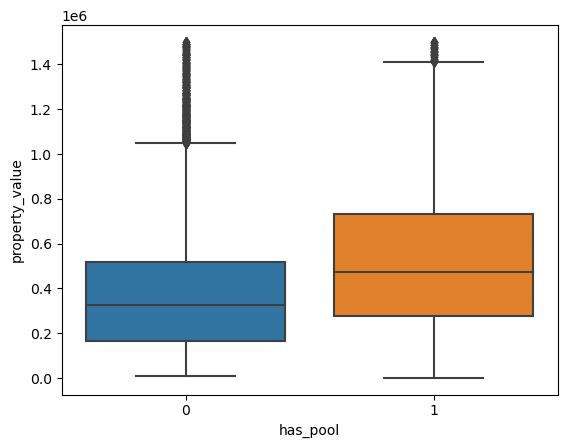

In [13]:
# get a boxplot of has_pool vs property_value on train
e.get_box_plot(train, 'has_pool')

### Analyze has_pool vs property_value with stats
- $H_0$: There is NO relationship between has_pool and property_value
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Comparing a categorical to a continuous variable, normally distributed, and equal variance
    - Testing if property value of has_pool == 1 is signicantly greater than has_pool == 0:  one-tail ttest
    - Utilize f_oneway

In [14]:
# get the stats from a f_oneway (one-tail ttest) on has_pool vs property_value
e.get_has_pool_f_oneway(train)

t = 1235.193036393532
p = 5.555880437217344e-265


### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between has_pool and property_value

## Exploration Summary
* Features that have a relationship with property_value (stats test for year, county, lotsize_sqft completed on separate working notebook:
    * squarefeet
    * bathrooms
    * bedrooms
    * has_pool
    * year
    * county
    * lotsize_sqft


# Modeling
* I will use R^2 and Root Mean Square Error (RMSE) as my evaluation metrics
    * for R^2, the value is in the range 0-1; closer to 1.0 is better; baseline is 0.0
    * for RMSE, the lower the value the better; baseline is $298,893
* The average property_value is 411,361 which is the baseline prediction
* I will evaluate four different model types and various hyperparameter configurations
    * The four model types are Ordinary Least Squares (OLS), LassoLars, Polynomial Regression, Generalized Linear Model (GLM)
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [15]:
# scaling continuous variable columns for use in modeling
to_scale = ['bathrooms', 'bedrooms', 'squarefeet', 'lotsize_sqft', 'year']
train_scaled, validate_scaled, test_scaled = w.get_minmax_scaled(train, validate, test, to_scale)

# get X y splits for modeling
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = m.get_X_y_baseline(train_scaled, validate_scaled, test_scaled)

## Comparing Models

In [16]:
# get metrics with all columns
m.get_reg_model_metrics_df(X_train_scaled, y_train, X_validate_scaled, y_validate)

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,298892.655016,0.000000,304361.745050,-0.000210
1,ols,248287.419729,0.309953,249166.780523,0.329666
2,LassoLars,248288.423831,0.309947,249175.886930,0.329617
3,Polynomial Regression,241928.292058,0.344847,243158.906096,0.361602
4,GLM,248287.419729,0.309953,249166.780753,0.329666


## Top 3 Models
* 1. Polynomial Regression (degrees = 2)
* 2. Ordinary Least Squares (OLS)
* 3. LassoLars (alpha = 1)

Sending in all features produced the best models.

* All models beat the baseline
* All models were similar, but Polynomial Regression was a clear front-runner
* I have chosen to move forward on the test data (unseen data) with Polynomial Regression

## Polynomial Regression on test

In [17]:
m.print_poly_reg_metrics(X_train_scaled, y_train, X_test_scaled, y_test)

RMSE on train is 241928.2920576337
R^2 on train is 0.3448468502989358

RMSE on test is 242448.3976046919
R^2 on test is 0.33275056274418036


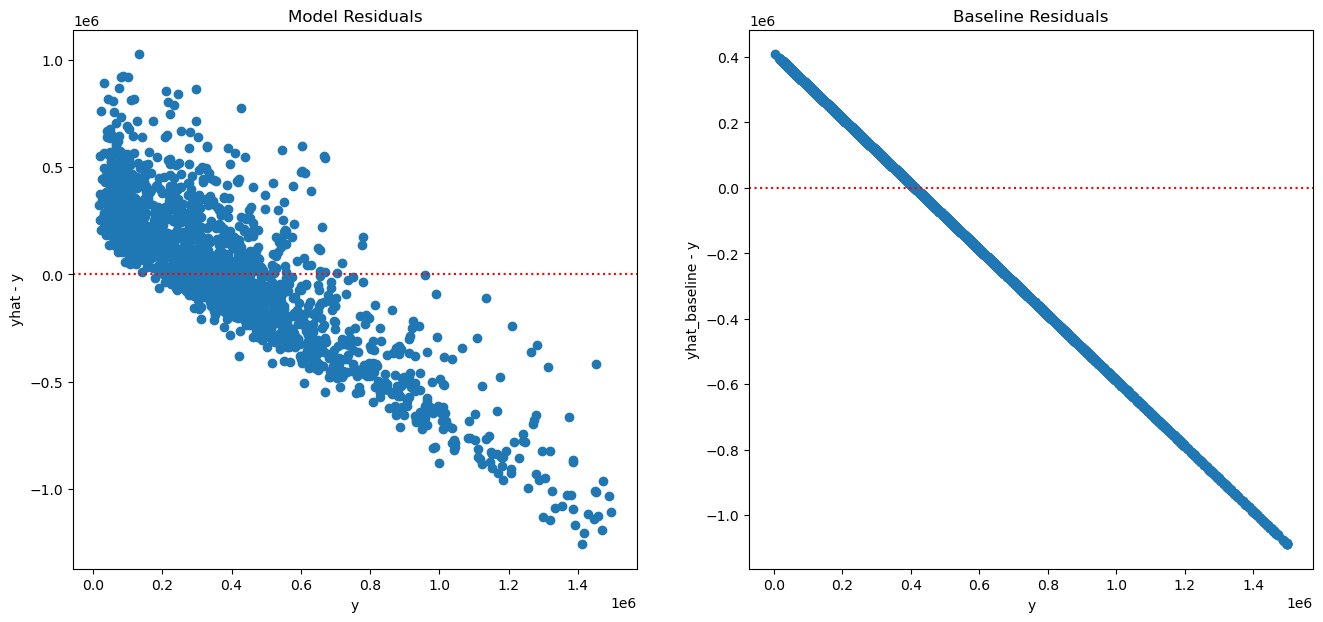

In [18]:
# plot residuals of best model's predictions on test
ev.plot_poly_residuals(X_train_scaled, y_train, X_test_scaled, y_test)

## Modeling Summary
* When evaluated on unseen data, the selected Polynomial Regression model had a R^2 of .33 and RMSE of 242,448
* This model beats the baseline (the mean) which had a R^2 of 0.0 and RMSE of 298,893

# Conclusions
## Exploration
* The average property value in the dataset is $411,361
* Features affecting property value (in rank order):

    1) squarefeet:   higher squarefeet        -> higher property_value
    2) bathrooms :   more bathrooms           -> higher property_value
    3) bedrooms  :   more bedrooms            -> higher property_value
    4) year      :   higher year (newer home) -> higher property value
    5) has_pool  :   properties WITH a pool   -> higher property value
    6) county    :   Orange/Ventura           -> higher property value
    7) lotsize_sqft: higher lotsize_sqft      -> higher property value

## Modeling
* The final model outperformed the baseline (aka the mean property value), but there is a lot of room for improvement


    * Final Model R^2: .33
    * Final Model RMSE: 242,448
    
    * Baseline R^2: 0.0
    * Baseline RMSE: 298,893

## Recommendations
* Given the RMSE value is still so high, I would not use this model as the primary source of estimating home value
* That said, there are clear correlations between the features in my model and property value; it just needs a bit more refinement

## Next steps
* With more time, I would like to include location data
    * I would start with latitude and longitude
    * I would make separate models based on county, though I'm not convinced this will be significant because the counties are so big
    * I would investigate how to use some of the other location columns, such as regionidcity, regionidzip, and censustractandblock
        * regionidneighborhood seems like it could be useful, but this column had nulls for ~60% of the dataset
        * My hypothesis is that calculating a neighborhood's mean price per square foot and multiplying that number by the square feet of the home one is trying to predict, would beat my best model
        * This would require access to neighborhood property values, however, which is outside of the boundaries of what we were asked to do
* With more time, I would also investigate other sklearn models
* If able, I would access state/county property value assessment data from the previous year and either include this in the model, or use it as a baseline because I think it will be reasonably accurate.
* As always, consider collecting more data, such as school district, which specific schools are associated with a property, and those schools' performance metrics

In [19]:
%%html 
<style>
  table {margin-left: 0 !important;}
</style>